In [1]:
from sympy.printing.pretty.pretty_symbology import line_width
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt

PLOT_DIR = "../experiments/plots"

In [26]:
search_data = {
    "num_entities": [10_000, 25_000, 50_000, 75_000, 100_000, 150_000, 200_000, 250_000, 375_000, 500_000, 625_000, 750_000, 875_000, 1_000_000],
    "Exact":[2.798,6.482,13.683,20.145,25.788,38.183,52.098,64.081,97.705,129.498,169.355,202.125,239.98,281.573],
    "MultiVecHNSW": [0.572,0.625,0.759,0.750,0.774,0.815,0.824,0.962,1.015,1.143,1.148,1.158,1.147,1.187],
    "HNSWRerank": [1.561,2.186,2.664,3.267,3.513,4.516,4.994,5.294,5.960,7.061,7.508,8.540,9.272,8.939]
}


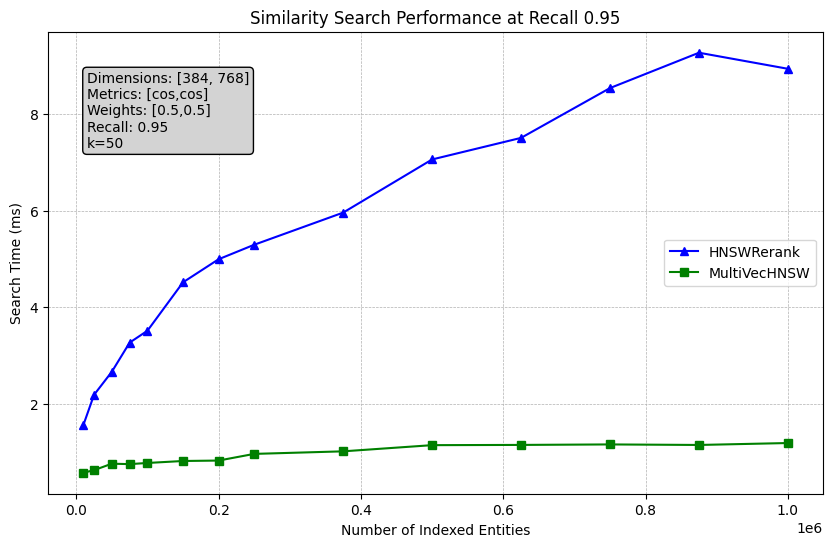

In [30]:
plt.figure(figsize=(10, 6))
plt.plot(search_data["num_entities"], search_data["Exact"], marker='o', linestyle='-', label='Sequential Search', color='red')
plt.plot(search_data["num_entities"], search_data["HNSWRerank"], marker='^', linestyle='-', label='HNSWRerank', color='blue')
plt.plot(search_data["num_entities"], search_data["MultiVecHNSW"], marker='s', linestyle='-', label='MultiVecHNSW', color='green')

#plt.xscale('log')
#plt.yscale('log')

plt.xlabel('Number of Indexed Entities')
plt.ylabel('Search Time (ms)')
plt.title('Similarity Search Performance at Recall 0.95')
plt.legend()

# info box
info_text = ("Dimensions: [384, 768]\nMetrics: [cos,cos]\nWeights: [0.5,0.5]\nRecall: 0.95\nk=50")
plt.annotate(info_text, xy=(0.05, 0.75), xycoords='axes fraction', 
             bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='lightgray'))

plt.grid(True, which="both", linestyle="--", linewidth=0.5)

# save plot
#plt.savefig(f"{PLOT_DIR}/similarity_search_performance.png", dpi=900, bbox_inches='tight')

plt.show()

In [27]:
construction_data =  {
    "num_entities": [10_000, 25_000, 50_000, 75_000, 100_000, 150_000, 200_000, 250_000, 375_000, 500_000, 625_000, 750_000, 875_000, 1_000_000],
    "MultiVecHNSW": [13.57,41.440,96.85,144.69,200.67,314.693376,430.1843251,550.52,870.79,1170.12,1447.72,1783.51,2128.36,2575.93],
    "HNSWRerank": [15.96,53.86,125.21,202.61,276.81,438.93,607.42,777.03,1222.65,1683.63,2166.75,2708.79,3164.55,3838.43]
}

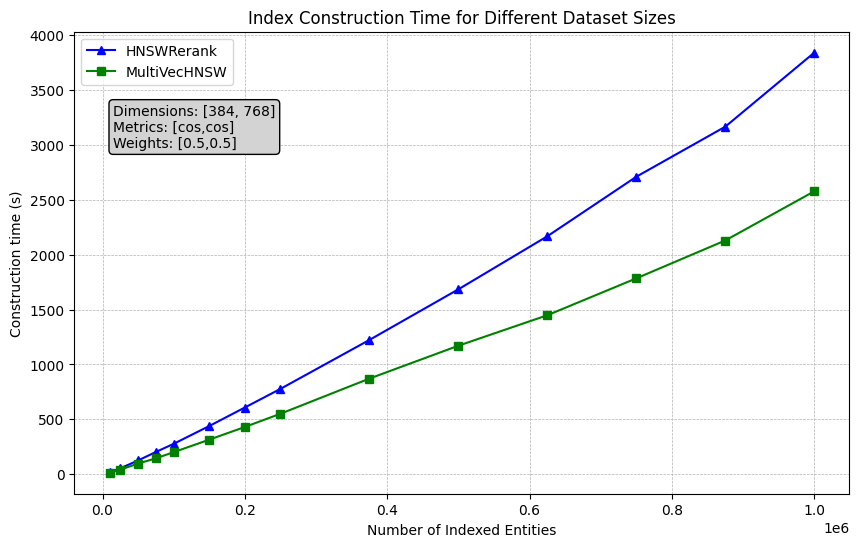

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(construction_data["num_entities"], construction_data["HNSWRerank"], marker='^', linestyle='-', label='HNSWRerank', color='blue')
plt.plot(construction_data["num_entities"], construction_data["MultiVecHNSW"], marker='s', linestyle='-', label='MultiVecHNSW', color='green')

plt.xscale('log')
plt.yscale('log')


plt.xlabel('Number of Indexed Entities')
plt.ylabel('Construction time (s)')
plt.title('Index Construction Time for Different Dataset Sizes')
plt.legend()

# info box
info_text = ("Dimensions: [384, 768]\nMetrics: [cos,cos]\nWeights: [0.5,0.5]")
plt.annotate(info_text, xy=(0.05, 0.75), xycoords='axes fraction', 
             bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='lightgray'))


plt.grid(True, which="both", linestyle="--", linewidth=0.5)

# save plot
plt.savefig(f"{PLOT_DIR}/index_construction.png", dpi=900, bbox_inches='tight')

plt.show()

In [45]:
from src.evaluation_params import Params, MultiVecHNSWConstructionParams, MultiVecHNSWSearchParams 
from src.evaluation import sanitise_path_string, compute_recall
import os
import numpy as np
from collections import defaultdict

In [255]:
BASE_DIR = "/Users/yavuz/scalable-multimodal-similarity-search/experiments/"
CONSTRUCTION_DIR = BASE_DIR + "construction/"
SEARCH_DIR = BASE_DIR + "search/"
EXACT_RESULTS_FOLDER = BASE_DIR + "exact_results/"

RERANK_CONSTRUCTION_DIR = BASE_DIR + "rerank_construction/"
RERANK_SEARCH_DIR = BASE_DIR + "rerank_search/"


In [23]:
def get_construction_folder(params: Params):
    save_folder = sanitise_path_string(
        f"{params.modalities}_{params.dimensions}_{params.metrics}_{params.weights}_{params.index_size}/")
    return save_folder

def get_hnsw_construction_params_folder(specific_params: MultiVecHNSWConstructionParams):
    save_folder = sanitise_path_string(
        f"{specific_params.target_degree}_{specific_params.max_degree}_{specific_params.ef_construction}_{specific_params.seed}/")
    return save_folder

def get_exact_results_folder(params: Params):
    save_folder = sanitise_path_string(
        f"{params.modalities}_{params.dimensions}_{params.metrics}_{params.weights}_{params.index_size}_{params.k}/")
    return save_folder

In [293]:
from scipy import stats

def compute_mean_and_ci_stats(data, confidence=0.95):
    # data is a list of numbers
    mean = np.mean(data)
    sem = stats.sem(data)
    conf_bound = (1. + confidence) / 2. # e.g. 0.995 for 99% CI
    ci = sem * stats.t.ppf(conf_bound, len(data) - 1)
    return mean, ci

In [24]:
p = Params(modalities=2, dimensions=[384, 768], metrics=["cos", "cos"], weights=[0.5, 0.5], index_size=10_000)
p.k=50
get_exact_results_folder(p)

'2_:384,768:_:cos,cos:_:0.5,0.5:_10000_50/'

In [276]:
def get_latest_experiment_file(folder):
    files = os.listdir(folder)
    # get the latest experiment file (file name is time)
    files.sort()
    data_file = files[-1] 
    return data_file


def get_matching_experiment_folder(folder, query_ids):
    subfolders = os.listdir(folder)
    subfolders.sort(reverse=True) # start search from latest
    for subfolder in subfolders:
        if subfolder.startswith("."):
            continue
        
        # get files in the subfolder
        ef_folders = os.listdir(folder + "/" + subfolder)
        
        # get a ef folder in the subfolder
        ef_folders.sort(reverse=True)
        for ef_folder in ef_folders:
            if ef_folder.startswith("."):
                continue
            # load query_ids.npy file
            query_ids_file = os.path.join(folder, subfolder, ef_folder, "query_ids.npy")
            loaded_query_ids = np.load(query_ids_file)

            # check if queries are the same
            if np.array_equal(query_ids, loaded_query_ids):
                return folder + "/" + subfolder
                    
    assert False, f"Could not find matching experiment folder for query_ids: {query_ids}"

In [388]:
def read_exact_results_times(params, num_entities, search_dir=EXACT_RESULTS_FOLDER):
    exact_search_times = {}
    query_ids_dict = {}
    for num_entity in num_entities:
        params.index_size = num_entity
        search_folder = search_dir + get_exact_results_folder(params)
        
        # get the latest experiment file
        data_folder = get_latest_experiment_file(search_folder)
        
        # read results.npz file
        data_file = os.path.join(search_folder, data_folder, "results.npz")
        query_ids_file = os.path.join(search_folder, data_folder, "query_ids.npy")
        
        #load the data
        query_ids = np.load(query_ids_file)
        times = np.load(os.path.join(search_folder, data_file))["search_times"]
        assert len(times) == len(query_ids) == 1000
        
        query_ids_dict[num_entity] = query_ids
        exact_search_times[num_entity] = times
        
    return exact_search_times, query_ids_dict


def find_results_at_target_recall(ef_folders_root, target_recall=0.95):
    ef_folders = os.listdir(ef_folders_root)
    # remove any folder that starts with "."
    ef_folders = [ef_folder for ef_folder in ef_folders if not ef_folder.startswith(".")]
    # sort the folders by ef value
    ef_folders.sort(key= lambda x: int(x.split("_")[1]))
    
    for ef_folder in ef_folders:
        # load results.npz file
        results = np.load(os.path.join(ef_folders_root, ef_folder, "results.npz"))
        # results contains search_times, recall_scores, ef_search, results
        assert ef_folder.split("_")[1] == str(results["ef_search"])
        # get recall scores
        recall_scores = results["recall_scores"]
        
        # check if we have the target recall
        if np.mean(recall_scores) >= target_recall:
            return results["ef_search"], results["search_times"]
        
    assert False, f"Could not find results at target recall {target_recall} in {ef_folders_root}"
        
    
def read_search_times(params, construction_params, num_entities, query_ids_dict, search_base_folder):
    search_times = {}
    recall_achieving_ef = {}
    for num_entity in num_entities:
        params.index_size = num_entity
        query_ids = query_ids_dict[num_entity]
                
        search_folder = search_base_folder + get_construction_folder(params) + get_hnsw_construction_params_folder(construction_params)
        
        data_folder = get_matching_experiment_folder(search_folder, query_ids)
        
        if construction_params.target_degree == 32:
            target_recall = 0.95
        else:
            target_recall = 0.9
        recall_achieving_ef[num_entity], search_times[num_entity] = find_results_at_target_recall(data_folder, target_recall)
    
    return search_times, recall_achieving_ef    


def convert_to_ms(search_times_dict):
    for num_entity in search_times_dict:
        search_times_dict[num_entity] = [x * 1000 for x in search_times_dict[num_entity]]
    return search_times_dict
    

def plot_search_results_with_baselines(params, construction_params, num_entities, exact_search_times, search_times_multivechnsw, search_times_rerankhnsw, title="Similarity Search Performance at Recall 0.95"):
    confidence = 0.99
    linewidth = 1
    # convert to ms
    search_times_multivechnsw = convert_to_ms(search_times_multivechnsw)
    search_times_rerankhnsw = convert_to_ms(search_times_rerankhnsw)
    exact_search_times = convert_to_ms(exact_search_times)
    
    means_multivechnsw = []
    means_rerankhnsw = []
    means_exact = []
    cis_multivechnsw = []
    cis_rerankhnsw = []
    cis_exact = []
    for num_entity in num_entities:
        mean_multivechnsw, ci_multivechnsw = compute_mean_and_ci_stats(search_times_multivechnsw[num_entity], confidence)
        mean_rerankhnsw, ci_rerankhnsw = compute_mean_and_ci_stats(search_times_rerankhnsw[num_entity], confidence)
        mean_exact, ci_exact = compute_mean_and_ci_stats(exact_search_times[num_entity], confidence)
        
        means_multivechnsw.append(mean_multivechnsw)
        means_rerankhnsw.append(mean_rerankhnsw)
        means_exact.append(mean_exact)
        
        cis_multivechnsw.append(ci_multivechnsw)
        cis_rerankhnsw.append(ci_rerankhnsw)
        cis_exact.append(ci_exact)
        
    # convert to numpy
    means_multivechnsw = np.array(means_multivechnsw)
    means_rerankhnsw = np.array(means_rerankhnsw)
    means_exact = np.array(means_exact)
    cis_multivechnsw = np.array(cis_multivechnsw)
    cis_rerankhnsw = np.array(cis_rerankhnsw)
    cis_exact = np.array(cis_exact)
    
    plt.figure(figsize=(10, 6))
    
    plt.plot(num_entities, means_exact, marker='o', linestyle='-', label='ExactMultiVecIndex', color='red', linewidth=linewidth)
    plt.fill_between(num_entities, 
                     means_exact - cis_exact, 
                     means_exact + cis_exact,
                     color='red', alpha=0.2)
    
    plt.plot(num_entities, means_rerankhnsw, marker='s', linestyle='-', label='HNSWRerank', color='blue', linewidth=linewidth)
    plt.fill_between(num_entities,
                        means_rerankhnsw - cis_rerankhnsw,
                        means_rerankhnsw + cis_rerankhnsw,
                        color='blue', alpha=0.2)
    
    plt.plot(num_entities, means_multivechnsw, marker='^', linestyle='-', label='MultiVecHNSW', color='green', linewidth=linewidth)
    plt.fill_between(num_entities,
                        means_multivechnsw - cis_multivechnsw,
                        means_multivechnsw + cis_multivechnsw,
                        color='green', alpha=0.2)
    
    plt.xscale('log')
    plt.yscale('log')

    plt.xlabel('Number of Indexed Entities')
    plt.ylabel('Search Time (ms)')
    plt.title(title)
    plt.legend()

    # info box
    info_text = f"Dimensions: {params.dimensions}\nMetrics: {params.metrics}\nWeights: {params.weights}\nTarget Degree: {construction_params.target_degree}\nMax Degree: {construction_params.max_degree}\nEf Construction: {construction_params.ef_construction}"
    plt.annotate(info_text, xy=(0.05, 0.75), xycoords='axes fraction', 
                 bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='lightgray'))

    plt.grid(True, which="both", linestyle="--", linewidth=0.5)

    # save plot
    plt.savefig(f"{PLOT_DIR}/similarity_search_performance_with_baselines_efC{construction_params.ef_construction}.png", dpi=900, bbox_inches='tight')

    plt.show()
    

In [389]:
params = Params(modalities=2, dimensions=[384, 768], metrics=["cosine", "cosine"], weights=[0.5, 0.5], index_size=None, k=50)
construction_params = MultiVecHNSWConstructionParams(target_degree=32, max_degree=32, ef_construction=200, seed=1)
num_entities = [10_000, 25_000, 50_000, 75_000, 100_000, 150_000, 200_000, 250_000, 375_000, 500_000, 625_000, 750_000, 875_000, 1_000_000]
exact_search_times, query_ids_dict = read_exact_results_times(params, num_entities)

In [390]:
search_times_multivechnsw, recall_achieving_ef_multivechnsw  = read_search_times(params, construction_params, num_entities, query_ids_dict, search_base_folder=SEARCH_DIR)

In [391]:
search_times_rerankhnsw, recall_achieving_ef_rerankhnsw  = read_search_times(params, construction_params, num_entities, query_ids_dict, search_base_folder=RERANK_SEARCH_DIR)

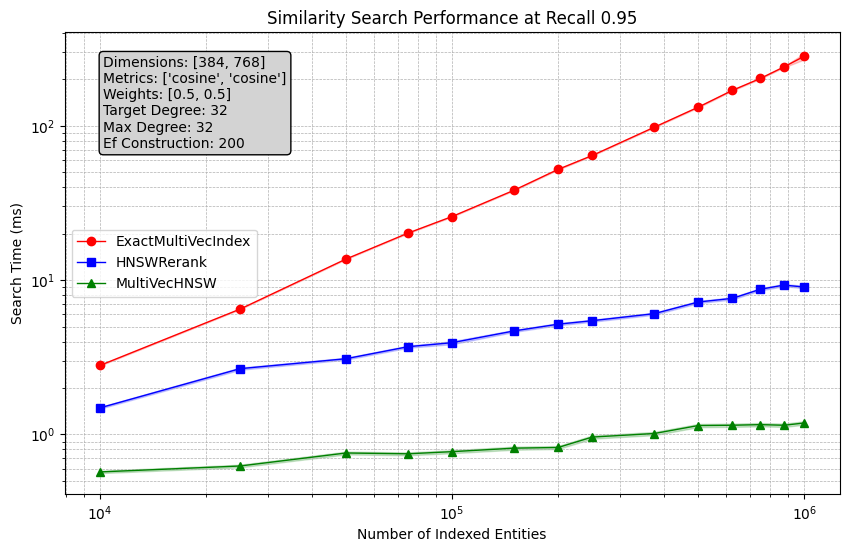

In [392]:
plot_search_results_with_baselines(params, construction_params, num_entities, exact_search_times, search_times_multivechnsw, search_times_rerankhnsw, title="Similarity Search Performance at Recall 0.95")

In [393]:
params = Params(modalities=2, dimensions=[384, 768], metrics=["cosine", "cosine"], weights=[0.5, 0.5], index_size=None, k=50)
construction_params = MultiVecHNSWConstructionParams(target_degree=16, max_degree=16, ef_construction=100, seed=1)
num_entities = [10_000, 25_000, 50_000, 75_000, 100_000, 150_000, 200_000, 250_000, 375_000, 500_000, 625_000, 750_000, 875_000, 1_000_000]
exact_search_times, query_ids_dict = read_exact_results_times(params, num_entities)

In [394]:
search_times_multivechnsw, recall_achieving_ef_multivechnsw  = read_search_times(params, construction_params, num_entities, query_ids_dict, search_base_folder=SEARCH_DIR)

In [395]:
search_times_rerankhnsw, recall_achieving_ef_rerankhnsw  = read_search_times(params, construction_params, num_entities, query_ids_dict, search_base_folder=RERANK_SEARCH_DIR)

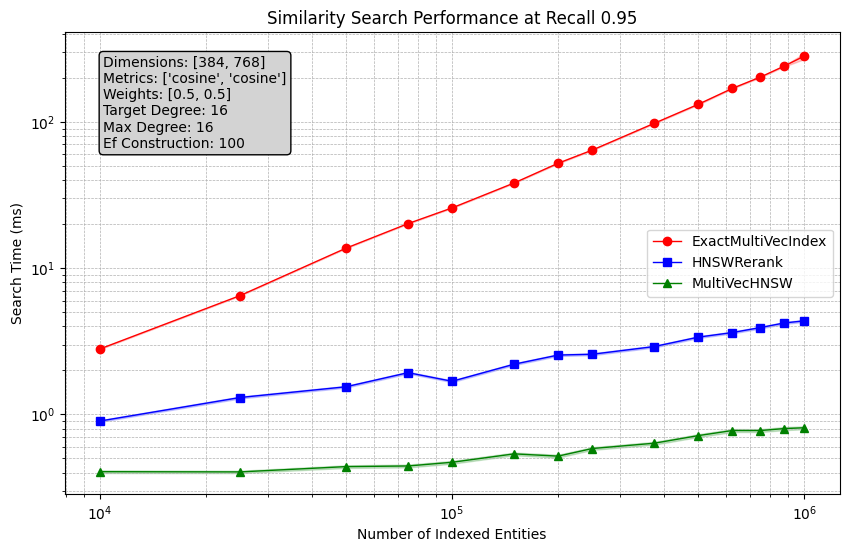

In [396]:
plot_search_results_with_baselines(params, construction_params, num_entities, exact_search_times, search_times_multivechnsw, search_times_rerankhnsw, title="Similarity Search Performance at Recall 0.95")

In [259]:
def read_construction_times(params, specific_construction_params, num_entities, construction_dir=CONSTRUCTION_DIR, rerank_construction_dir=RERANK_CONSTRUCTION_DIR):
    
    hnsw_construction_times = defaultdict(list)
    rerank_construction_times = defaultdict(list)
   
    for num_entity in num_entities:
        params.index_size = num_entity

        # MultiVecHNSW
        construction_folder = construction_dir + get_construction_folder(params) + get_hnsw_construction_params_folder(specific_construction_params)
        
        data_file = get_latest_experiment_file(construction_folder)
       
        # load the .npz file
        data = np.load(os.path.join(construction_folder, data_file))["time"]
        
        # get the time
        hnsw_construction_times[num_entity].append(data[0])
        
        # HNSWRerank
        rerank_construction_folder = rerank_construction_dir + get_construction_folder(params) + get_hnsw_construction_params_folder(specific_construction_params)
        
        rerank_data_file = get_latest_experiment_file(rerank_construction_folder)
        
        rerank_indexes_times = np.load(os.path.join(rerank_construction_folder, rerank_data_file))["time"]
        rerank_construction_times[num_entity].append(sum(rerank_indexes_times))
        
    return hnsw_construction_times, rerank_construction_times

def plot_construction_times(params, specific_construction_params, num_entities, hnsw_construction_times, rerank_construction_times, log_scale=True):
    
    hnsw_construction_times = [hnsw_construction_times[num_entity][0] for num_entity in num_entities]
    rerank_construction_times = [rerank_construction_times[num_entity][0] for num_entity in num_entities]
    
    print("hnsw_construction_times", hnsw_construction_times)
    print("rerank_construction_times", rerank_construction_times)
    
    plt.figure(figsize=(10, 6))
    plt.plot(num_entities, rerank_construction_times, marker='^', linestyle='-', label='HNSWRerank', color='blue')
    plt.plot(num_entities, hnsw_construction_times, marker='s', linestyle='-', label='MultiVecHNSW', color='green')

    if log_scale:
        plt.xscale('log')
        plt.yscale('log')

    plt.xlabel('Number of Indexed Entities')
    plt.ylabel('Construction time (s)')
    plt.title('Index Construction Time for Different Dataset Sizes')
    plt.legend()

    # info box
    info_text = f"Dimensions: {params.dimensions}\nMetrics: {params.metrics}\nWeights: {params.weights}\nTarget Degree: {specific_construction_params.target_degree}\nMax Degree: {specific_construction_params.max_degree}\nEf Construction: {specific_construction_params.ef_construction}"
    plt.annotate(info_text, xy=(0.05, 0.75), xycoords='axes fraction', 
                 bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='lightgray'))

    plt.grid(True, which="both", linestyle="--", linewidth=0.5)

    # save plot
    log = "_log" if log_scale else ""
    plt.savefig(f"{PLOT_DIR}/index_construction_{specific_construction_params.target_degree}_{specific_construction_params.max_degree}_{specific_construction_params.ef_construction}{log}.png", dpi=900, bbox_inches='tight')

    plt.show()

In [92]:
params = Params(modalities=2, dimensions=[384, 768], metrics=["cosine", "cosine"], weights=[0.5, 0.5], index_size=None)
num_entities = [10_000, 25_000, 50_000, 75_000, 100_000, 150_000, 200_000, 250_000, 375_000, 500_000, 625_000, 750_000, 875_000, 1_000_000]

hnsw_construction_times [6.346126283984631, 17.804628984013107, 39.64612390997354, 60.864943734020926, 83.28804606705671, 129.9761373049696, 182.11468165297993, 230.77338604297256, 367.96823897300055, 487.2876910569903, 616.4465098340006, 748.6142987450003, 895.9518034690118, 1085.0214689970016]
rerank_construction_times [7.208573153009638, 26.793852773989784, 59.21474285502336, 91.69017516198801, 112.31948494998505, 179.1377694280236, 248.4462096450152, 310.53323954500956, 485.7419640640146, 670.4287378599984, 861.9539020800148, 1055.0087702860183, 1270.8737307340198, 1471.409669007]


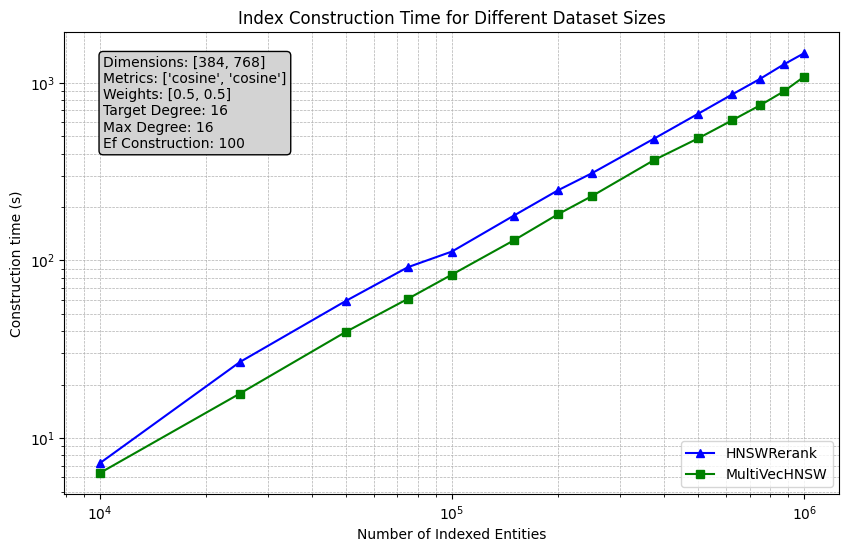

In [93]:
construction_params = MultiVecHNSWConstructionParams(target_degree=16, max_degree=16, ef_construction=100, seed=1)
hnsw_construction_times, rerank_construction_times = read_construction_times(params, construction_params, num_entities)
plot_construction_times(params, construction_params, num_entities, hnsw_construction_times, rerank_construction_times)

In [ ]:
construction_params2 = MultiVecHNSWConstructionParams(target_degree=32, max_degree=32, ef_construction=200, seed=1)

hnsw_construction_times2, rerank_construction_times2 = read_construction_times(params, construction_params2, num_entities)
plot_construction_times(params, construction_params2, num_entities, hnsw_construction_times2, rerank_construction_times2)

In [119]:
def plot_hnsw_construct_with_different_params(num_entities, params, construction_params1, construction_params2, timesdict1, timesdict2, log_scale=False):
    times1 = [timesdict1[num_entity][0] for num_entity in num_entities]
    times2 = [timesdict2[num_entity][0] for num_entity in num_entities]
    
    plt.figure(figsize=(10, 6))
    plt.plot(num_entities, times1, marker='o',linestyle='-', label=f'MultiVecHNSW {construction_params1.target_degree}, {construction_params1.ef_construction}')
    plt.plot(num_entities, times2, marker='o', linestyle='-', label=f'MultiVecHNSW {construction_params2.target_degree}, {construction_params2.ef_construction}')
    
    if log_scale:
        plt.xscale('log')
        plt.yscale('log')

    plt.xlabel('Number of Indexed Entities')
    plt.ylabel('Construction time (s)')
    plt.title('Index Construction Time for Different Construction Settings')
    plt.legend()

    # info box
    info_text = f"Dimensions: {params.dimensions}\nMetrics: {params.metrics}\nWeights: {params.weights}"
    plt.annotate(info_text, xy=(0.05, 0.75), xycoords='axes fraction', 
                 bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='lightgray'))

    plt.grid(True, which="both", linestyle="--", linewidth=0.5)

    # save plot
    log = "_log" if log_scale else ""
    plt.savefig(f"{PLOT_DIR}/index_construction_hnsw_comparison{log}.png", dpi=900, bbox_inches='tight')
    
    # change ticklabel format to plain
    if not log_scale:
        ax = plt.gca()
        ax.ticklabel_format(style='sci', axis='x')
    
    plt.show()

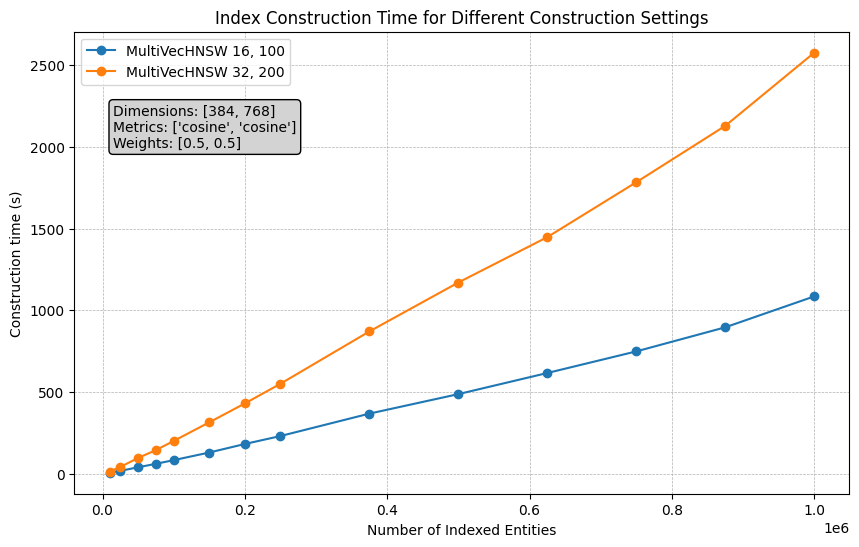

In [120]:
plot_hnsw_construct_with_different_params(num_entities, params, construction_params, construction_params2, hnsw_construction_times, hnsw_construction_times2)

In [246]:
def get_ef_exp_data(params, construction_params, search_base_folder=SEARCH_DIR):
    search_folder = search_base_folder + get_construction_folder(params) + get_hnsw_construction_params_folder(construction_params)
    
    selected_folder = get_latest_experiment_file(search_folder)
    ef_folders = os.listdir(search_folder +"/"+ selected_folder)
    ef_folders.sort()
    
    recall_scores_per_ef = {}
    search_times_per_ef = {}
    for ef_folder in ef_folders:
        if ef_folder.startswith("."):
            continue
        stats = ef_folder.split("_")
        k = int(stats[0])
        ef = int(stats[1])
        
        # load results.npz file
        results = np.load(os.path.join(search_folder, selected_folder, ef_folder, "results.npz"))
        # results contains search_times, recall_scores, ef_search, results
        assert ef == results["ef_search"]
        assert ef not in recall_scores_per_ef
        recall_scores_per_ef[ef] = results["recall_scores"]
        search_times_per_ef[ef] = results["search_times"]
    
    return recall_scores_per_ef, search_times_per_ef


def plot_ef_exp_data(params, construction_params, recall_scores_per_ef, search_times_per_ef, title="Impact of efSearch on Recall and Search Time"):
    ef_values = sorted(recall_scores_per_ef.keys()) # skip first
    num_results = None
    for k,v in search_times_per_ef.items():
        search_times_per_ef[k] = [x * 1000 for x in v] # convert to ms
        num_results = len(search_times_per_ef[k])
        
    print(f"Averaged {num_results} query results")

    mean_recalls = []
    mean_times = []
    ci_recalls = []
    ci_times = []
    for ef in ef_values:
        mean_recall, ci_recall = compute_mean_and_ci_stats(recall_scores_per_ef[ef])
        mean_search_time, ci_search_time = compute_mean_and_ci_stats(search_times_per_ef[ef])
        
        mean_recalls.append(mean_recall)
        mean_times.append(mean_search_time)
        ci_recalls.append(ci_recall)
        ci_times.append(ci_search_time)
    
    mean_recalls = np.array(mean_recalls)
    mean_times = np.array(mean_times)
    ci_recalls = np.array(ci_recalls)
    ci_times = np.array(ci_times)
        
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    # plot recall on the left axis
    ax1.plot(ef_values, mean_recalls, '-o', color='blue', label='Recall')
    ax1.fill_between(ef_values, 
                     mean_recalls - ci_recalls, 
                     mean_recalls + ci_recalls,
                     color='blue', alpha=0.2)
    ax1.set_xlabel('efSearch', fontsize=12)
    ax1.set_ylabel('Recall', color='blue', fontsize=12)
    ax1.tick_params(axis='y', labelcolor='blue')
    # set upper limit to 1
    ax1.set_ylim(0.8, 1)
    
    # set x limit to be that of the ef values
    #ax1.set_xlim(min(ef_values)-10, max(ef_values)+10)
    
    # plot search time on the right axis
    ax2 = ax1.twinx()
    ax2.plot(ef_values, mean_times, '-s', color='red', label='Search Time')
    ax2.fill_between(ef_values, 
                     mean_times - ci_times, 
                     mean_times + ci_times,
                     color='red', alpha=0.2)
    ax2.set_ylabel('Search Time (ms)', color='red', fontsize=12)
    ax2.tick_params(axis='y', labelcolor='red')
    
    # set xticks
    ax1.set_xticks(ef_values)
    
    # info box
    info_text = f"Dimensions: {params.dimensions}\nMetrics: {params.metrics}\nWeights: {params.weights}\nTarget Degree: {construction_params.target_degree}\nMax Degree: {construction_params.max_degree}\nEf Construction: {construction_params.ef_construction}\nk: 50"
    plt.annotate(info_text, xy=(0.7, 0.05), xycoords='axes fraction', 
                 bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='lightgray'))

    # combine legends
    lines, labels = [], []
    for ax in [ax1, ax2]:
        ax_lines, ax_labels = ax.get_legend_handles_labels()
        lines.extend(ax_lines)
        labels.extend(ax_labels)
    ax1.legend(lines, labels, loc='upper left')
    
    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.title(title, fontsize=12)
    
    # save plot
    plt.savefig(f"{PLOT_DIR}/ef_against_recall_and_search_{params.index_size}_ef{construction_params.ef_construction}", dpi=900, bbox_inches='tight')
    
    plt.show()
        

Averaged 1000 query results


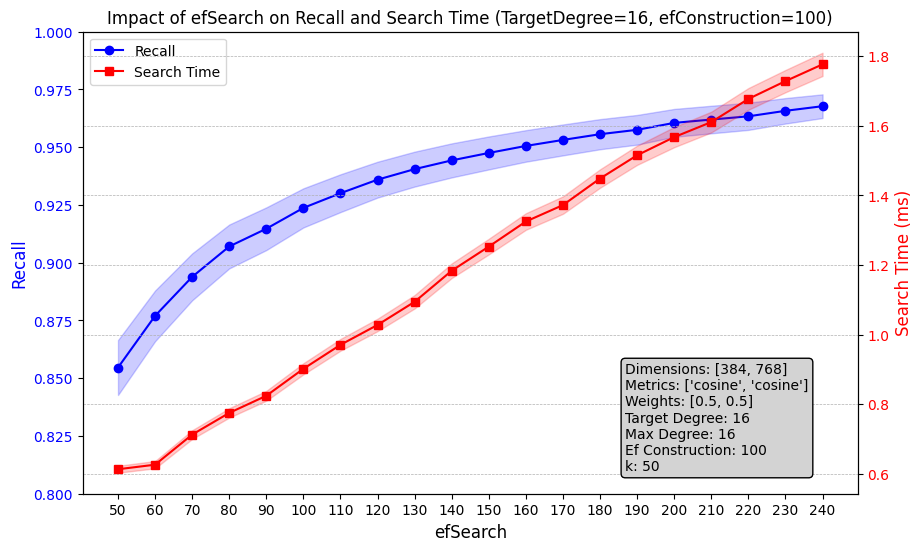

In [248]:
ef_exp_params = Params(modalities=2, dimensions=[384, 768], metrics=["cosine", "cosine"], weights=[0.5, 0.5], index_size=750_000)
ef_exp_construction_params = MultiVecHNSWConstructionParams(target_degree=16, max_degree=16, ef_construction=100, seed=1)
recall_scores_per_ef, search_times_per_ef = get_ef_exp_data(ef_exp_params, ef_exp_construction_params)
plot_ef_exp_data(ef_exp_params, ef_exp_construction_params, recall_scores_per_ef, search_times_per_ef, title="Impact of efSearch on Recall and Search Time (TargetDegree=16, efConstruction=100)")

Averaged 1000 query results


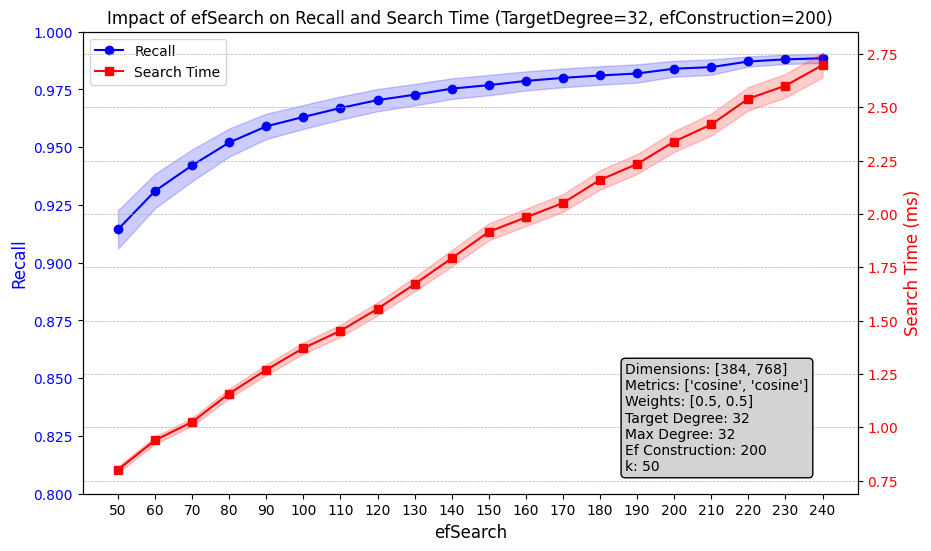

In [251]:
ef_exp_params = Params(modalities=2, dimensions=[384, 768], metrics=["cosine", "cosine"], weights=[0.5, 0.5], index_size=750_000)
ef_exp_construction_params = MultiVecHNSWConstructionParams(target_degree=32, max_degree=32, ef_construction=200, seed=1)
recall_scores_per_ef, search_times_per_ef = get_ef_exp_data(ef_exp_params, ef_exp_construction_params)
plot_ef_exp_data(ef_exp_params, ef_exp_construction_params, recall_scores_per_ef, search_times_per_ef, title="Impact of efSearch on Recall and Search Time (TargetDegree=32, efConstruction=200)")